## PyTorch

In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

In [3]:
dataset = MNIST(root='data/train', transform=ToTensor())
test_dataset = MNIST (root='data/test', train=False, transform=ToTensor())

In [4]:
len(dataset)

60000

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5
torch.Size([1, 28, 28])


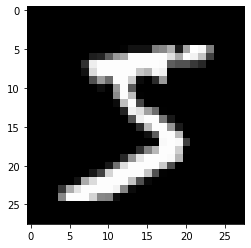

In [6]:
def show_image(num):
    image, label = dataset[num]
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    print('Label:', label)
    print(image.shape)
    
show_image(0)


Splitting the dataset between Training and Validation Dataset.

In [7]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [50000, 10000])
len(train_dataset), len(val_dataset)

(50000, 10000)

In [8]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)

In [9]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

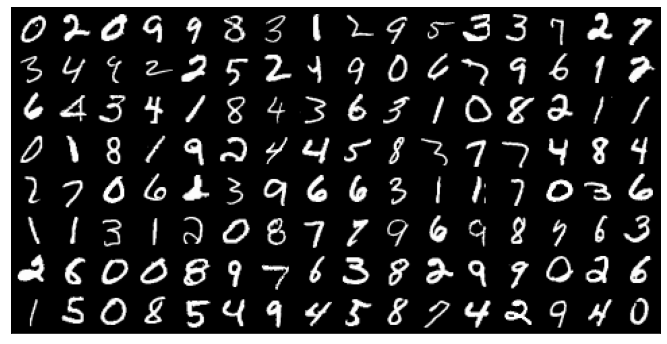

In [10]:
show_batch(train_loader)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [12]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class LeNet(ImageClassificationBase):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1,6,5, stride=1),                  
            nn.Sigmoid(),                      
            nn.AvgPool2d(2,stride=2),      
            nn.Conv2d(6,16,5),                 
            nn.Sigmoid(),
            nn.AvgPool2d(2,stride=2)            
            )
        
        self.fc_model = nn.Sequential(
            nn.Linear(256,120),
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.Sigmoid(),
            nn.Linear(84,10)   
            )
        
    def forward(self,x):     
        x = self.cnn_model(x)
        x = x.view(x.size(0),-1)
        x = self.fc_model(x)
        return x

In [14]:
model = LeNet()
model

LeNet(
  (cnn_model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [15]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape: ', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 28, 28])
out.shape:  torch.Size([128, 10])
out[0]: tensor([ 0.6041, -0.3886,  0.0842, -0.0670,  0.1599, -0.3574, -0.0057, -0.1607,
        -0.2706,  0.3530], grad_fn=<SelectBackward0>)


In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [17]:
device=get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device);

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(LeNet(), device)

In [21]:
evaluate(model, val_dl)

{'val_loss': 2.3184354305267334, 'val_acc': 0.10017800331115723}

In [22]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [23]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.5997, val_loss: 0.6585, val_acc: 0.8165
Epoch [1], train_loss: 0.4421, val_loss: 0.3364, val_acc: 0.9001
Epoch [2], train_loss: 0.2834, val_loss: 0.2541, val_acc: 0.9226
Epoch [3], train_loss: 0.2192, val_loss: 0.2024, val_acc: 0.9388
Epoch [4], train_loss: 0.1789, val_loss: 0.1701, val_acc: 0.9474
Epoch [5], train_loss: 0.1517, val_loss: 0.1527, val_acc: 0.9528
Epoch [6], train_loss: 0.1294, val_loss: 0.1381, val_acc: 0.9562
Epoch [7], train_loss: 0.1133, val_loss: 0.1221, val_acc: 0.9598
Epoch [8], train_loss: 0.1014, val_loss: 0.1127, val_acc: 0.9634
Epoch [9], train_loss: 0.0914, val_loss: 0.1083, val_acc: 0.9659


In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

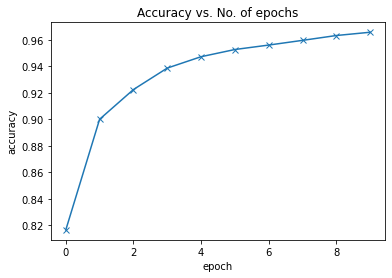

In [25]:
plot_accuracies(history)

In [26]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

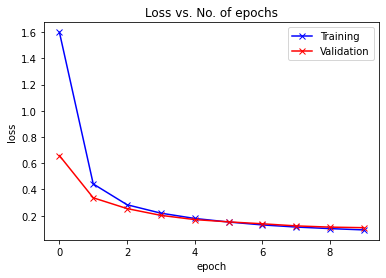

In [27]:
plot_losses(history)

In [28]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: 4 - four , Predicted: 4 - four


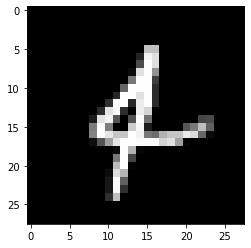

In [29]:
img, label = test_dataset[300]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))